In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
import gc
import os


## READING AND EXPLORING DATA

In [2]:
train= pd.read_csv('../input/sorghum-id-fgvc-9/train_cultivar_mapping.csv')

In [3]:
train.isnull().sum()

image       0
cultivar    1
dtype: int64

In [4]:
train_dir='../input/sorghum-id-fgvc-9/train_images/'

In [5]:
train=train.dropna(axis=0)

<AxesSubplot:>

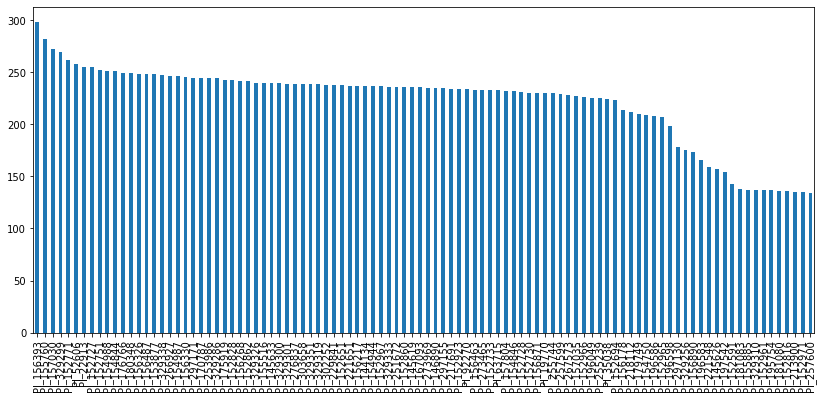

In [6]:
# iMAGES UNDER EACH LABEL
train['cultivar'].value_counts().plot(kind='bar', figsize=(14,6))

In [7]:
train['cultivar']=train['cultivar'].astype(str)

In [8]:
labels=list(np.unique(train['cultivar']))

## CREATING TRAIN AND VALIDATION SETS

#### AUGMENTATION

In [9]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator( rotation_range=.20,      
            shear_range=0.7,  
                                   
            horizontal_flip=True,         
            validation_split=0.2
)


In [10]:
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train,
    directory=train_dir,
    x_col='image',
    y_col='cultivar',
    color_mode='rgb',
    class_mode='categorical',
    classes=labels,

    
    target_size=(256, 256),
    batch_size=32,
    subset='training',
    shuffle=True
)

Found 17755 validated image filenames belonging to 100 classes.


In [11]:
valid_generator = train_datagen.flow_from_dataframe(
    dataframe=train,
    directory=train_dir,
    x_col='image',
    y_col='cultivar',
    color_mode='rgb',
   
    class_mode='categorical',
    classes=labels,
    target_size=(256, 256),
    batch_size=32,
    subset='validation',
    shuffle=True
)

Found 4438 validated image filenames belonging to 100 classes.


In [12]:
gc.collect()

95

## PRE-TRAINED MODEL EFFICIENTNET B2- trained on data for 7 epochs

In [13]:
model = keras.models.load_model('../input/training-sorghum-image-classification-xception-1-c/keras_model.h5', compile=False)

2022-05-28 06:06:47.073061: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-28 06:06:47.195226: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-28 06:06:47.195977: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-28 06:06:47.197116: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

### TEST PREDICTIONS

In [14]:
test=pd.read_csv('/kaggle/input/sorghum-id-fgvc-9/sample_submission.csv').drop('cultivar',axis=1)
test.head()

,filename
0,1000005362.png
1,1000099707.png
2,1000135300.png
3,1000136796.png
4,1000292439.png


In [15]:
test_dir='../input/sorghum-id-fgvc-9/test/'

In [16]:
test_datagen=tf.keras.preprocessing.image.ImageDataGenerator()
test_generator=test_datagen.flow_from_dataframe(test,test_dir, x_col='filename', color_mode='rgb', target_size=(256,256), shuffle=False, class_mode=None)

Found 23639 validated image filenames.


In [17]:
oh_preds=model.predict(test_generator)

2022-05-28 06:07:35.646163: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-05-28 06:07:38.718287: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


In [18]:
oh_preds.shape

(23639, 100)

In [19]:
pred_indices=np.argmax(oh_preds, axis=1)

In [20]:
predictions=[labels[i] for i in pred_indices]

In [21]:
test['cultivar']=predictions

In [22]:
test.head()

,filename,cultivar
0,1000005362.png,PI_180348
1,1000099707.png,PI_329333
2,1000135300.png,PI_176766
3,1000136796.png,PI_329256
4,1000292439.png,PI_155516


In [23]:
test.to_csv('submission.csv', index=False)

In [24]:

model.save('model1.h5')

/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
